In [91]:
# import libraries 
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

pd.set_option('display.max_columns', None)

In [61]:
# load batting_basic
batting_basic = pd.read_csv('Data/batting_basic', index_col = 0)
batting_basic.head()

,Season,Name,Team,Age,Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
0,2000.0,Jeff Abbott,CHW,27.0,255000.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738
1,2000.0,Kurt Abbott,NYM,31.0,500000.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672
2,2006.0,Reggie Abercrombie,FLA,24.0,327000.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604
3,2007.0,Reggie Abercrombie,FLA,25.0,327000.0,35.0,76.0,80.0,0.197,15.0,10.0,3.0,0.0,2.0,16.0,5.0,2.0,0.0,22.0,2.0,0.0,0.0,1.0,7.0,1.0,0.238,0.316,0.553
4,2008.0,Reggie Abercrombie,HOU,26.0,327000.0,34.0,55.0,60.0,0.309,17.0,10.0,5.0,0.0,2.0,10.0,5.0,1.0,0.0,23.0,2.0,1.0,1.0,0.0,5.0,2.0,0.339,0.509,0.848


In [62]:
batting_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11610 entries, 0 to 12653
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Season  11610 non-null  float64
 1   Name    11610 non-null  object 
 2   Team    11610 non-null  object 
 3   Age     11610 non-null  float64
 4   Salary  11610 non-null  float64
 5   G       11610 non-null  float64
 6   AB      11610 non-null  float64
 7   PA      11610 non-null  float64
 8   AVG     11610 non-null  float64
 9   H       11610 non-null  float64
 10  1B      11610 non-null  float64
 11  2B      11610 non-null  float64
 12  3B      11610 non-null  float64
 13  HR      11610 non-null  float64
 14  R       11610 non-null  float64
 15  RBI     11610 non-null  float64
 16  BB      11610 non-null  float64
 17  IBB     11610 non-null  float64
 18  SO      11610 non-null  float64
 19  HBP     11610 non-null  float64
 20  SF      11610 non-null  float64
 21  SH      11610 non-null  float64
 22

We likely dont need the following columns to determine our target variable of `Salary` so we can drop them moving forward:
- `Season`
- `Team`
- `Name`


In [63]:
batting_basic = batting_basic.drop(columns = ['Season', 'Name'])
batting_basic

,Team,Age,Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
0,CHW,27.0,255000.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738
1,NYM,31.0,500000.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672
2,FLA,24.0,327000.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604
3,FLA,25.0,327000.0,35.0,76.0,80.0,0.197,15.0,10.0,3.0,0.0,2.0,16.0,5.0,2.0,0.0,22.0,2.0,0.0,0.0,1.0,7.0,1.0,0.238,0.316,0.553
4,HOU,26.0,327000.0,34.0,55.0,60.0,0.309,17.0,10.0,5.0,0.0,2.0,10.0,5.0,1.0,0.0,23.0,2.0,1.0,1.0,0.0,5.0,2.0,0.339,0.509,0.848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12649,SEA,26.0,570000.0,124.0,387.0,435.0,0.251,97.0,47.0,25.0,0.0,25.0,52.0,64.0,39.0,0.0,160.0,8.0,1.0,0.0,8.0,1.0,0.0,0.331,0.509,0.840
12650,SEA,27.0,2975000.0,113.0,373.0,405.0,0.201,75.0,37.0,18.0,0.0,20.0,37.0,44.0,24.0,0.0,150.0,6.0,2.0,0.0,7.0,0.0,0.0,0.259,0.410,0.669
12651,TBR,28.0,4412000.0,90.0,266.0,289.0,0.165,44.0,24.0,10.0,1.0,9.0,30.0,32.0,20.0,0.0,98.0,3.0,0.0,0.0,4.0,0.0,0.0,0.232,0.312,0.544
12652,TBR,29.0,4500000.0,28.0,75.0,84.0,0.147,11.0,3.0,4.0,0.0,4.0,8.0,10.0,6.0,0.0,37.0,3.0,0.0,0.0,0.0,0.0,0.0,0.238,0.360,0.598


## Train-Test Split

In [64]:
# feature selection, target variable = 'Salary'
X = batting_basic.drop(['Salary'], axis = 1)
y = batting_basic['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8707, 25)
(2903, 25)
(8707,)
(2903,)


## Define the Pipelines

In [114]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) # apply a standard scaler

# define a nominal transformation pipeline that OHE the cats, and MaxAbsScales the set
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories="auto", # ohe the cat variables
                                sparse = False, 
                                drop = 'first'))]) 

In [115]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [116]:
# transform the selected columns with nominal, and numeric pipelines
ct = ColumnTransformer(transformers = 
                    [("nominalpipe", nominal_pipeline, cat_cols), 
                     ("numpipe", numeric_pipeline, num_cols)])

In [117]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_bb_X_train = pd.DataFrame(ct.fit_transform(X_train))
pp_bb_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.053229,-1.172421,-1.218545,-1.212512,-1.521146,-1.192606,-1.145078,-1.194126,-0.733075,-0.837123,-1.217034,-1.084546,-1.160525,-0.552066,-0.996842,-0.567979,-0.974840,1.715339,-1.175064,-0.598960,-0.719921,-2.132691,-1.445923,-1.773543
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.634291,0.261291,0.126566,0.111567,-1.290411,-0.373039,-0.401254,-0.515631,-0.733075,0.172159,-0.365082,-0.044173,-0.035360,0.261090,1.240307,0.547859,-0.549209,0.010261,-0.632588,-0.475023,-0.719921,-0.914658,-0.681493,-0.801145
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393216,0.151005,-0.130666,-0.112288,1.074624,0.064063,0.094629,-0.091572,-0.258123,0.172159,0.028127,0.443502,0.006313,-0.281014,-0.386710,-0.289020,1.578946,-0.671770,-0.270937,-0.103212,-0.335713,0.888032,0.960615,0.975352
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393216,-1.370936,-1.256058,-1.241089,-0.405926,-1.156181,-1.117529,-1.109314,-0.258123,-0.938051,-0.954895,-1.019522,-0.827143,-0.552066,-0.869731,-0.846939,-0.974840,-0.330754,-1.175064,-0.598960,-0.719921,0.238414,-0.823054,-0.452079
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571080,-0.003395,0.239105,0.206824,-0.348242,-0.008787,-0.180861,0.078052,-0.258123,0.575871,0.093662,0.345967,0.047986,-0.281014,-0.107067,-0.289020,0.302053,-0.671770,-0.090112,-0.598960,-0.719921,-0.313761,0.290560,0.071520


In [118]:
pp_bb_X_train.shape

(8707, 57)

In [119]:
# get feature names after encoding
cat_feature_names = list(nominal_pipeline.named_steps['onehotenc'].fit(X_train[cat_cols]).get_feature_names())

/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [120]:
# removes the OHE strings at front end of feature names
def clean_features(lst):
    new_list = []
    for value in lst:
        splitted = value.split('_')[1] # returns name of feature after '_'
        new_list.append(splitted)
        continue
    return new_list

In [121]:
cat_feature_names = clean_features(cat_feature_names)

In [122]:
num_features_names = list(num_cols)

In [123]:
# instantiate the linear regression model
lr_model = LinearRegression()
lr_model

# Fit our model
lr_model.fit(pp_bb_X_train, log_y_train)

# Get our R2 score
print('Linear Regression Model R2:', round(lr_model.score(pp_bb_X_train, log_y_train), 4))
print()

Linear Regression Model R2: 0.4791



In [124]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)

    # If using an older version of sklearn:
    # rmse = np.sqrt(mean_squared_error(y_true, y_predict))

    # Return the score
    return [r2, rmse]


In [125]:
pp_bb_X_test = pd.DataFrame(ct.fit_transform(X_test))
pp_bb_X_test 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.094875,0.774192,0.660713,0.570139,0.044632,0.463794,0.628946,0.236426,-0.263225,0.055824,0.160649,0.111709,-0.236298,-0.551612,-0.103726,-0.032078,-0.555716,1.021393,0.259288,0.044008,0.785851,-0.335181,-0.176192,-0.245113
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.853244,-0.818793,-0.607610,-0.637612,1.163421,-0.399715,-0.182920,-0.776132,0.666389,-0.767841,-0.535517,-0.579534,-0.581789,-0.551612,-0.537242,-0.596451,-0.979362,-0.668703,-0.629814,0.044008,0.785851,0.828045,0.185127,0.440413
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.336507,-0.221423,-0.051707,-0.060201,-0.977709,-0.399715,-0.490869,-0.354233,0.666389,-0.150092,-0.071406,-0.349119,-0.149925,-0.551612,0.584800,-0.314264,-0.132070,0.683374,-1.163275,0.566528,0.408148,-0.793918,-0.442428,-0.597311
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.563073,0.818442,1.081688,1.104244,1.124842,1.327303,0.936896,1.248984,-0.728032,2.629775,1.519832,1.790442,1.145666,0.286342,0.814309,-0.032078,1.986160,-0.668703,0.437109,-0.609141,-0.347258,1.008263,1.820575,1.597633
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.838178,1.216688,1.124865,1.335209,0.314685,0.978225,0.712932,1.924023,1.596003,0.158782,1.320927,0.539621,2.829935,0.286342,1.298827,-0.032078,1.138868,0.345355,1.504031,0.174638,3.052070,1.106564,0.346770,0.654247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.611612,0.995440,0.698493,0.608633,0.912658,0.849617,0.488969,0.995845,3.920037,0.879488,0.757364,1.132115,-0.279484,-0.551612,1.426332,-0.314264,-0.555716,0.007336,-0.096353,0.305268,0.408148,0.320158,1.392696,1.044180
2899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.853244,-1.084290,-1.001599,-0.998493,0.102501,-0.914145,-0.882805,-1.029271,0.201582,-0.664883,-0.900176,-0.941613,-0.711348,0.286342,-0.690248,-0.596451,-0.555716,-0.668703,-0.451993,-0.478511,-0.347258,0.238240,0.147094,0.188844
2900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.128349,1.216688,1.421706,1.320773,0.951237,1.584518,1.972725,0.911465,1.596003,0.158782,0.956268,1.230864,0.325125,0.007024,-0.435238,0.532295,1.138868,-0.330684,1.859672,0.697158,0.030445,0.483992,0.308737,0.390099
2901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.369980,-1.637410,-1.287647,-1.272764,0.507579,-1.134616,-1.162758,-1.029271,-0.728032,-0.664883,-0.900176,-0.974530,-0.840907,-0.551612,-1.327772,-0.596451,-0.979362,-0.668703,-0.985455,-0.609141,-0.724961,1.139331,1.097935,1.163675


In [126]:
pp_bb_X_test.shape

(2903, 57)

In [127]:
y_test.shape

(2903,)

In [128]:
y_train.shape

(8707,)

In [129]:
pp_bb_X_train.shape

(8707, 57)

In [130]:
# apply a log scale on the target variable 
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

In [131]:
log_y_train

11074    13.137449
5095     14.538217
10932    12.889169
8277     13.104199
2487     14.731801
           ...    
12282    13.458836
5658     14.914123
5873     12.935793
938      15.274126
7936     15.473739
Name: Salary, Length: 8707, dtype: float64

In [132]:
log_y_test

7972     12.933621
11447    13.147056
5297     13.102161
4604     16.341239
3851     16.341239
           ...    
2286     13.083623
5040     12.666657
10674    16.213406
2050     13.152602
8628     16.705882
Name: Salary, Length: 2903, dtype: float64

In [133]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state = 45)

# Fit the model to training data
regressor.fit(pp_bb_X_train, log_y_train)

# Make predictions on the test data
y_pred = regressor.predict(pp_bb_X_test)

# Calculate performance using the performance() function 
score = performance(log_y_test, y_pred)
score # R2, RMSE

[0.06899900239633938, 1.2849544712036285]

In [134]:
from sklearn.ensemble import RandomForestRegressor

rfr =  RandomForestRegressor()

# Fit to the training data
rfr.fit(pp_bb_X_train, log_y_train)

# Make predictions on the test data
y_pred = rfr.predict(pp_bb_X_test)

# Calculate performance using the performance() function 
score = performance(log_y_test, y_pred)
score # R2, RMSE

[0.5389190107246289, 0.9042765628579077]

In [135]:
np.exp(0.908248)

2.479973810899592

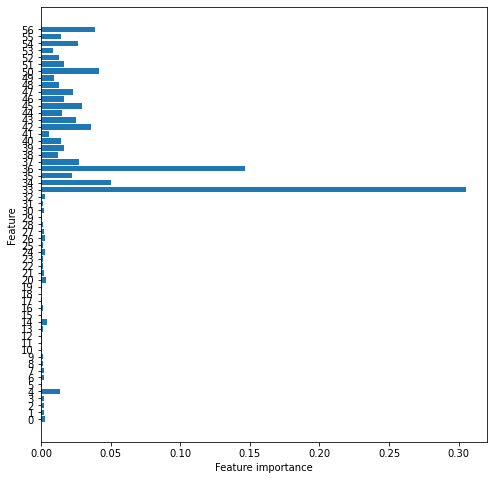

In [36]:
def plot_feature_importances(model):
    n_features = pp_bb_X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), pp_bb_X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(regressor)

In [38]:
pp_bb_X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.053229,-1.172421,-1.218545,-1.212512,-1.521146,-1.192606,-1.145078,-1.194126,-0.733075,-0.837123,-1.217034,-1.084546,-1.160525,-0.552066,-0.996842,-0.567979,-0.974840,1.715339,-1.175064,-0.598960,-0.719921,-2.132691,-1.445923,-1.773543
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.634291,0.261291,0.126566,0.111567,-1.290411,-0.373039,-0.401254,-0.515631,-0.733075,0.172159,-0.365082,-0.044173,-0.035360,0.261090,1.240307,0.547859,-0.549209,0.010261,-0.632588,-0.475023,-0.719921,-0.914658,-0.681493,-0.801145
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393216,0.151005,-0.130666,-0.112288,1.074624,0.064063,0.094629,-0.091572,-0.258123,0.172159,0.028127,0.443502,0.006313,-0.281014,-0.386710,-0.289020,1.578946,-0.671770,-0.270937,-0.103212,-0.335713,0.888032,0.960615,0.975352
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.393216,-1.370936,-1.256058,-1.241089,-0.405926,-1.156181,-1.117529,-1.109314,-0.258123,-0.938051,-0.954895,-1.019522,-0.827143,-0.552066,-0.869731,-0.846939,-0.974840,-0.330754,-1.175064,-0.598960,-0.719921,0.238414,-0.823054,-0.452079
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571080,-0.003395,0.239105,0.206824,-0.348242,-0.008787,-0.180861,0.078052,-0.258123,0.575871,0.093662,0.345967,0.047986,-0.281014,-0.107067,-0.289020,0.302053,-0.671770,-0.090112,-0.598960,-0.719921,-0.313761,0.290560,0.071520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.812154,-0.753336,-0.838056,-0.841008,-1.040448,-0.919417,-0.842038,-0.854878,-0.733075,-0.837123,-1.020429,-0.759429,-0.702125,-0.552066,-0.539243,-0.567979,-0.549209,0.010261,-0.994239,-0.598960,-0.335713,-0.865936,-1.257175,-1.162677
8703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088932,1.518546,1.359138,1.321337,0.190139,1.120393,0.810905,1.180606,0.216830,1.787008,1.437125,1.483875,0.631405,-0.009962,1.723328,1.105778,1.153315,0.692293,0.994841,0.268599,0.816910,0.076009,0.752993,0.526553
8704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.393216,-0.444537,-0.688003,-0.679070,-0.944308,-0.810141,-0.869588,-0.685255,0.216830,-0.534338,-0.627221,-0.661894,-0.577106,-0.552066,-0.183333,-0.846939,-0.549209,1.374324,-0.632588,0.144662,1.969534,-0.833455,-0.426683,-0.601678
8705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088932,1.364146,1.434164,1.240368,0.170911,1.175031,1.306788,1.010982,0.691782,0.374015,0.388569,0.996200,-0.493761,0.261090,0.070888,-0.289020,3.281470,-0.671770,1.718143,-0.103212,0.816910,-0.606089,-0.020875,-0.246379


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        9.000e+01, 4.590e+03, 2.493e+03, 1.533e+03]),
 array([ 0.        ,  1.74618304,  3.49236608,  5.23854912,  6.98473216,
         8.73091519, 10.47709823, 12.22328127, 13.96946431, 15.71564735,
        17.46183039]),
 <BarContainer object of 10 artists>)

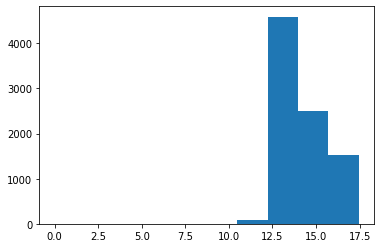

In [29]:
plt.hist(log_y_train)

(array([   6.,  257., 1022.,  244.,  217.,  267.,  340.,  281.,  210.,
          59.]),
 array([11.51292546, 12.10033825, 12.68775104, 13.27516382, 13.86257661,
        14.44998939, 15.03740218, 15.62481496, 16.21222775, 16.79964053,
        17.38705332]),
 <BarContainer object of 10 artists>)

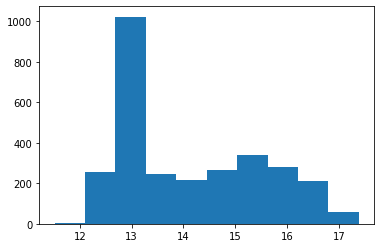

In [30]:
plt.hist(log_y_test)

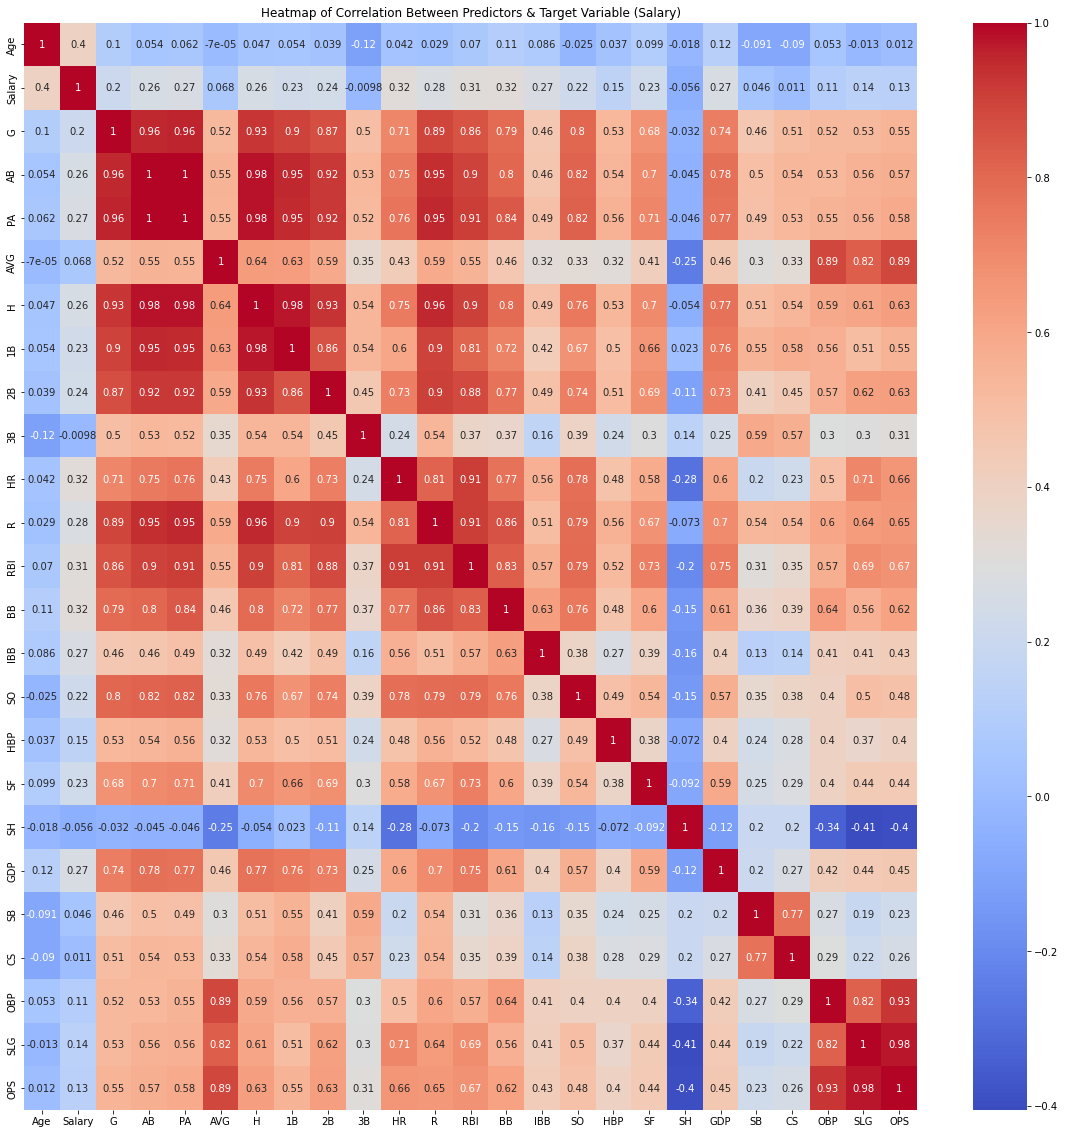

In [39]:
# set up figure size
fig, ax = plt.subplots(figsize=(20, 20))

# set up correlation matrix
corr = batting_basic.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Salary)");

plt.show()

In [ ]:
# instantiate the linear regression model
lr_model = LinearRegression()
lr_model

# Fit our model
lr_model.fit(pp_bb_X_train, y_train)

# Get our R2 score
print('Linear Regression Model R2:', round(lr_model.score(pp_bb_X_train, y_train), 4))
print()